In [117]:
#std lib
from collections import OrderedDict
from getpass import getpass
import warnings
warnings.filterwarnings('ignore') # to suppress some astropy deprecation warnings

# 3rd party
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
#from astropy import utils, io, convolution, wcs
#from astropy.visualization import make_lupton_rgb"
#from astropy.coordinates import name_resolve
#from pyvo.dal import sia
%matplotlib inline

# Data Lab
#from dl import authClient as ac, queryClient as qc, storeClient as sc
#from dl.helpers.utils import convert

In [118]:
# Dwarf names
#from Bechtol et al. (2015)
name = 'horologiumii' #''Leo V'
dwarf = pd.read_csv('dwarf_list.csv') 
mask = dwarf['NAME'] == name
dwarf = dwarf[mask] 

In [119]:
#data = pd.read_csv('dwarf_list.csv')  

In [120]:
#mask = data['NAME'] == name
#dwarf = data[mask] 

In [121]:
median_ra = (dwarf['RA']).values[0] #35.697018 #(dwarf['RA']).values[0]
print(median_ra)

49.1


In [122]:
median_dec = (dwarf['DEC']).values[0] #35.697018 #(dwarf['RA']).values[0]
print(median_dec)

-50.0


In [123]:
ra_bins = np.linspace(0, 360, 72+1)
dec_bins = np.linspace(-90,90, 36+1)

for i in range(len(ra_bins)):
    if (ra_bins[i] > median_ra):
        if ( ra_bins[i] - median_ra > 4):
            i2 = i-1
        else:
            i2 = i+1
        break

for j in range(len(dec_bins)):
    if (dec_bins[j] > median_dec):
        if ( dec_bins[j] - median_dec > 4):
            j2 = j-1
        else:
            j2 = j+1
        break

if i2 == 73: i2 = 1
if i2 == -1: i2 = 72
if j2 == 37: j2 = 1
if j2 == -1: j2 = 36
#print(ra_bins[73])

In [124]:

group_key_ra = 'RA_%d_%d/'%(ra_bins[i-1], ra_bins[i])
group_key_dec = 'DEC_%d_%d'%(dec_bins[j-1], dec_bins[j])
group_key_ra2 = 'RA_%d_%d/'%(ra_bins[i2-1], ra_bins[i2])
group_key_dec2 = 'DEC_%d_%d'%(dec_bins[j2-1], dec_bins[j2])

loc = group_key_ra + group_key_dec
loc1 = group_key_ra2 + group_key_dec
loc2 = group_key_ra + group_key_dec2
loc3 = group_key_ra2 + group_key_dec2
print(loc)

RA_45_50/DEC_-50_-45


In [125]:
import h5py
import tables

#data = pd.DataFrame()
#with pd.HDFStore('/oak/stanford/orgs/kipac/edarragh/gaiadr2.hdf5', mode='r') as newstore:
#data = pd.DataFrame(columns = ('ra', 'dec', 'parallax', 'pmra', 'pmdec', 'bp-rp', 'photo_g_mean_mag'))

#data.append(pd.read_hdf('/oak/stanford/orgs/kipac/edarragh/gaiadr2.hdf5', loc, columns = ('ra', 'dec', 'parallax', 'pmra', 'pmdec', 'bp-rp', 'photo_g_mean_mag'))) 
#data.append(pd.read_hdf('/oak/stanford/orgs/kipac/edarragh/gaiadr2.hdf5', loc1))
#data.append(pd.read_hdf('/oak/stanford/orgs/kipac/edarragh/gaiadr2.hdf5', loc2))
#data.append(pd.read_hdf('/oak/stanford/orgs/kipac/edarragh/gaiadr2.hdf5', loc3))
data = pd.read_hdf('/oak/stanford/orgs/kipac/edarragh/gaiadr2.hdf5', loc)
data1 = pd.read_hdf('/oak/stanford/orgs/kipac/edarragh/gaiadr2.hdf5', loc1)
data2 = pd.read_hdf('/oak/stanford/orgs/kipac/edarragh/gaiadr2.hdf5', loc2)
data3 = pd.read_hdf('/oak/stanford/orgs/kipac/edarragh/gaiadr2.hdf5', loc3)

print((data1))
print((data2))
print((data3))



data = data.append(data1)
data = data.append(data2)
data = data.append(data3)


print(np.min(data['ra']))
#ra = (store['RA_50_55/DEC_-55_-50']['ra'])
#dec = (store['RA_50_55/DEC_-55_-50']['dec'])
#pmra = (store['RA_50_55/DEC_-55_-50']['pmra'])
#pmdec = (store['RA_50_55/DEC_-55_-50']['pmdec'])
#parallax = (store['RA_50_55/DEC_-55_-50']['parallax'])
mask = data['ra'] > median_ra - 1
mask1 = data['ra'] < median_ra  +  1
mask2 = data['dec'] > median_dec -  1
mask3 = data['dec'] < median_dec +  1
mask4 = data['parallax'] < 0.1

data = data[mask & mask1 & mask2 & mask3 & mask4]

mask = data['pmra'] > -4
mask1 = data['pmra'] < 4
mask2 = data['pmdec'] > -4
mask3 = data['pmdec'] < 4

data = data[mask & mask1 & mask2 & mask3]

#dec = dec[mask & mask1 & mask2 & mask3 & mask4]
#pmra = pmra[mask & mask1 & mask2 & mask3 & mask4]
#pmdec = pmdec[mask & mask1 & mask2 & mask3 & mask4]
#parallax = parallax[mask & mask1 & mask2 & mask3 & mask4]
mask = (np.invert(np.isnan(data['parallax'])))
mask1 = (np.invert(np.isnan(data['ra'])))
mask2 = (np.invert(np.isnan(data['dec'])))
mask3 = (np.invert(np.isnan(data['pmra'])))
mask4 = (np.invert(np.isnan(data['pmdec'])))

data = data[mask & mask1 & mask2 & mask3 & mask4]
#dec = dec[mask & mask1 & mask2 & mask3 & mask4]
#pmra = pmra[mask & mask1 & mask2 & mask3 & mask4]
#pmdec = pmdec[mask & mask1 & mask2 & mask3 & mask4]
#parallax = parallax[mask & mask1 & mask2 & mask3 & mask4]


print(np.min(data['ra']))
#store.close()

               solution_id                   designation            source_id  \
22     1635721458409799680  Gaia DR2 4736656411257008768  4736656411257008768   
194    1635721458409799680  Gaia DR2 4736658713358657536  4736658713358657536   
600    1635721458409799680  Gaia DR2 4736658232322344320  4736658232322344320   
603    1635721458409799680  Gaia DR2 4736659022596307456  4736659022596307456   
685    1635721458409799680  Gaia DR2 4736656651774377984  4736656651774377984   
895    1635721458409799680  Gaia DR2 4736654280952418176  4736654280952418176   
1176   1635721458409799680  Gaia DR2 4736659915949511680  4736659915949511680   
1510   1635721458409799680  Gaia DR2 4736642697426064512  4736642697426064512   
1715   1635721458409799680  Gaia DR2 4736653387599226880  4736653387599226880   
1796   1635721458409799680  Gaia DR2 4736657132810711680  4736657132810711680   
1803   1635721458409799680  Gaia DR2 4736658678998937728  4736658678998937728   
1876   1635721458409799680  

45.0000190170067
48.10434762814357


# Get DES x Gaia stars

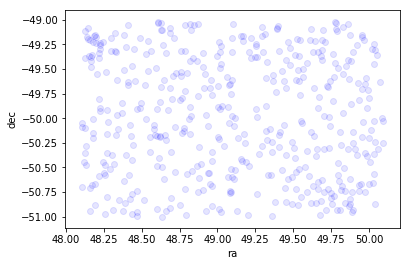

In [126]:
#ididx = dgaia_all['id'] != dg
plt.scatter(data['ra'], data['dec'], c='b',alpha=0.1)
#plt.scatter(dgaia_retii['ra'].values, dgaia_retii['dec'].values, c='m',alpha=0.005)
plt.xlabel('ra')
plt.ylabel('dec')
plt.show()


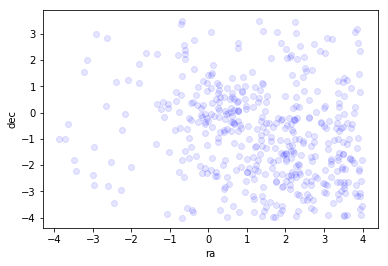

In [127]:
#ididx = dgaia_all['id'] != dg
plt.scatter(data['pmra'], data['pmdec'], c='b',alpha=0.1)
#plt.scatter(dgaia_retii['pmra'].values, dgaia_retii['pmdec'].values, c='m',alpha=0.005)
plt.xlabel('ra')
plt.ylabel('dec')
plt.show()

In [128]:
from scipy.stats import poisson 

ra_min, ra_max = median_ra-1, median_ra+1
dec_min, dec_max = median_dec-1, median_dec+1
vra_min, vra_max =  -4, 4
vdec_min, vdec_max =  -4, 4

mask1 = data['pmdec'] > -4
mask2 = data['pmdec'] < 4
mask3 = data['pmra'] > -4
mask4 = data['pmra'] < 4

data1 = data[mask1 & mask2 & mask3 & mask4]

x = np.linspace(ra_min, ra_max, 50)
y = np.linspace(dec_min, dec_max, 50)
mean = np.zeros((49,49))
for i in range(len(x)-1):
    for j in range(len(y)-1):
        mask1 = data1['ra'] > x[i]
        mask2 = data1['ra'] < x[i+1]
        mask3 = data1['dec'] > y[j]
        mask4 = data1['dec'] < y[j+1]  
        mean[i][j] = len(data1[mask1 & mask2 & mask3 & mask4])
print(np.mean(mean))  

rand_ra = []
rand_dec = [] 
for i in range(len(x)-1):
    for j in range(len(y)-1):
        num_points = poisson(np.mean(mean)).rvs()
        if num_points == 0:
            continue
        else: 
            rnd_ra = np.random.uniform(x[i], x[i+1], size=num_points)
            rnd_dec = np.random.uniform(y[j], y[j+1], size=num_points)
            for q in range(len(rnd_ra)): 
                rand_ra.append(rnd_ra[q]) 
                rand_dec.append(rnd_dec[q])
    


0.1874219075385256


In [129]:
from sklearn.mixture import GaussianMixture as GMM

X = np.array(list(zip(data1['pmra'], data1['pmdec'])))

gmm = GMM(n_components=3).fit(X)
print(gmm.get_params)

sample = gmm.sample(len(rand_ra))


<bound method BaseEstimator.get_params of GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)>


In [130]:
a= gmm.covariances_
print(a)

[[[ 2.53442004  0.18192721]
  [ 0.18192721  1.676619  ]]

 [[ 0.96478833 -0.03519941]
  [-0.03519941  1.3117925 ]]

 [[ 3.20519374 -0.28355695]
  [-0.28355695  1.21868279]]]


In [131]:
print(len(sample[0][:,0]))


445


In [132]:
rand_pmra = (sample[0][:,0]) #- np.mean(sample[0][:,0]))/np.std(sample[0][:,0])
rand_pmdec = (sample[0][:,1])# - np.mean(sample[0][:,1]))/np.std(sample[0][:,1])

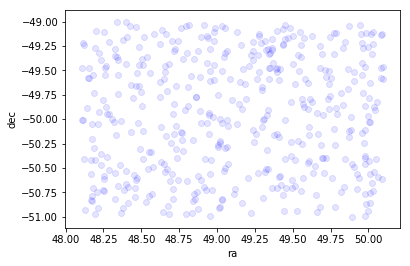

450
445


In [133]:
plt.scatter(rand_ra, rand_dec, c='b',alpha=0.1)
#plt.scatter(dgaia_retii['pmra'].values, dgaia_retii['pmdec'].values, c='m',alpha=0.005)
plt.xlabel('ra')
plt.ylabel('dec')
plt.show()

print(len(data))
print(len(rand_ra))

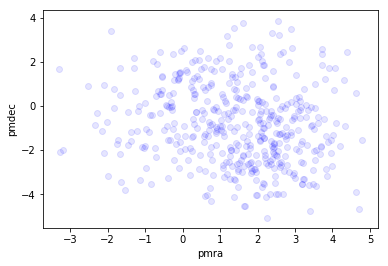

In [134]:
plt.scatter(rand_pmra, rand_pmdec, c='b',alpha=0.1)
#plt.scatter(dgaia_retii['pmra'].values, dgaia_retii['pmdec'].values, c='m',alpha=0.005)
plt.xlabel('pmra')
plt.ylabel('pmdec')
plt.show()

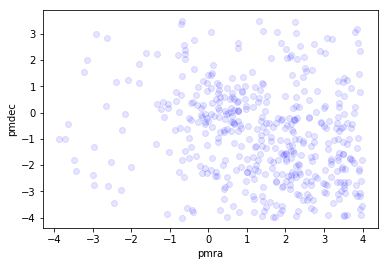

In [135]:
plt.scatter(data['pmra'], data['pmdec'], c='b',alpha=0.1)
#plt.scatter(dgaia_retii['pmra'].values, dgaia_retii['pmdec'].values, c='m',alpha=0.005)
plt.xlabel('pmra')
plt.ylabel('pmdec')
plt.show()

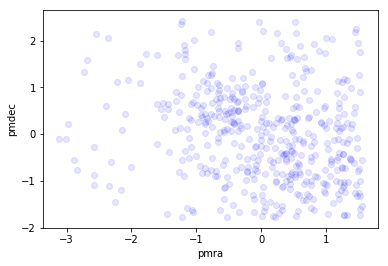

In [136]:
pmra = (data['pmra'] - np.mean(data['pmra']))/np.std(data['pmra'])
pmdec = (data['pmdec'] - np.mean(data['pmdec']))/np.std(data['pmdec'])
plt.scatter(pmra, pmdec, c='b',alpha=0.1)
#plt.scatter(dgaia_retii['pmra'].values, dgaia_retii['pmdec'].values, c='m',alpha=0.005)
plt.xlabel('pmra')
plt.ylabel('pmdec')
plt.show()

In [137]:
full_field = np.c_[data['ra'].as_matrix(), data['dec'].as_matrix(), data['pmra'].as_matrix(), data['pmdec'].as_matrix()]
#dwarf_field = np.c_[dgaia_retii['ra'].as_matrix(), dgaia_retii['dec'].as_matrix(), 
                #   dgaia_retii['pmra'].as_matrix(), dgaia_retii['pmdec'].as_matrix()]
random_field = np.c_[rand_ra, rand_dec, rand_pmra, rand_pmdec]
full_field[:,0]

array([49.88337902, 49.93372717, 49.83025526, 49.73374343, 49.98769028,
       49.99465484, 49.99694406, 49.32347361, 49.89680653, 49.06745224,
       48.59136715, 48.22603658, 49.78632585, 49.58753434, 48.72493351,
       48.33682245, 48.52528567, 49.84626165, 48.7593238 , 48.1777965 ,
       48.90571847, 49.6306822 , 49.61333529, 48.54401456, 49.25135869,
       48.15383393, 49.88320774, 48.3816788 , 49.85988651, 49.92207092,
       48.76346306, 48.91801749, 49.25319592, 49.68111366, 48.22767626,
       49.38808249, 48.69983979, 48.79832201, 48.70619591, 49.72369679,
       48.84752833, 49.11775021, 48.37235093, 49.73966466, 48.22207014,
       48.75005155, 48.53993845, 49.86204548, 48.4980651 , 49.42713524,
       49.76297987, 49.77592345, 48.16812473, 49.00491231, 49.66102058,
       49.26219422, 48.16109459, 48.71242721, 49.82660284, 49.16572956,
       48.33924285, 49.56712765, 49.53584845, 49.32763002, 49.08863905,
       48.96419121, 49.22101002, 48.2011449 , 49.30297772, 49.43

In [138]:


def make_field_image(full_field, vra_min, vra_max,vdec_min, vdec_max, n_pos= 97, n_vel=97):
    pos_min, pos_max =  np.min(full_field, axis =0)[:2], np.max(full_field, axis =0)[:2]
    ra_min, ra_max = median_ra-1, median_ra+1
    dec_min, dec_max = median_dec-1, median_dec+1
    
    
    vra_min, vra_max = -4, 4 
    vdec_min, vdec_max = -4, 4 


    field_image, edges = np.histogramdd(full_field,\
                            bins=(np.linspace(ra_min, ra_max, n_pos),
                                  np.linspace(dec_min, dec_max, n_pos), 
                                  np.linspace(vra_min, vra_max, n_vel),
                                  np.linspace(vdec_min, vdec_max, n_vel) ) )
    
    return field_image, edges

In [139]:
field_image, edges = make_field_image(full_field, vra_min, vra_max,vdec_min, vdec_max)
random_image, edges = make_field_image(random_field, vra_min, vra_max,vdec_min, vdec_max)
#print(np.mean(random_image))

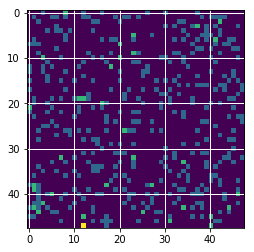

In [140]:
plt.imshow(field_image.sum(axis = (2,3)).T)
plt.grid(color='w', linestyle='-', linewidth=1)


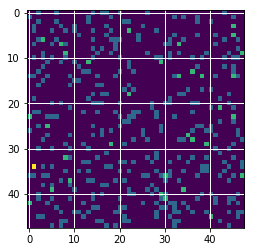

In [141]:
plt.imshow(random_image.sum(axis = (2,3)).T)
plt.grid(color='w', linestyle='-', linewidth=1)


In [142]:
from scipy import ndimage


def filter_layer(im, l = [2.0]):
    " return im filtered by the l filters"
    
    return np.stack([ndimage.filters.gaussian_filter(im, l) for l in l])

In [143]:
filtered_ims = field_image 

#ndimage.filters.gaussian_filter(field_image, 3.0)
#plt.imshow(ndimage.filters.gaussian_filter(filtered_ims.sum(axis = (2,3)).T, 6.0), origin='lower')
#plt.grid(color='w', linestyle='-', linewidth=1)
#plt.show()

#plt.imshow(ndimage.filters.gaussian_filter(filtered_ims.sum(axis = (0,1)).T, 6.0), origin='lower')
#plt.grid(color='w', linestyle='-', linewidth=1)
#plt.show()

In [144]:
#sigma_rd = np.std(random_image.sum(axis = (2,3)).T)
#sigma_rpr = np.std(random_image.sum(axis = (1,3)).T)
#sigma_dpd = np.std(random_image.sum(axis = (0,2)).T)

#print(sigma_rd)


In [145]:
from skimage import measure 
from skimage.feature import canny 
def find_labels(thresh):
   # mm = np.min(thresh)
  #  thresh = thresh/mm

    mask = thresh != 0 
    temp_thresh = np.copy(thresh) 
    thresh[mask] = 255 
    labels = measure.label(thresh, neighbors=8, background=0)
    print(labels)
    for label in np.unique(labels):

        if label == 0:
            continue
        
        mask = labels == label 
        labels[mask] = 1 
        num_pix = np.sum(labels[mask])
#        if num_pix > 10:
#            continue
#        else:
#            labels[mask] = 0 
    temp_thresh[labels==0] = 0 
   # thresh[labels==1] = 1
    return temp_thresh

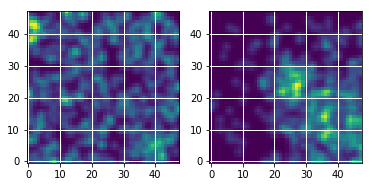

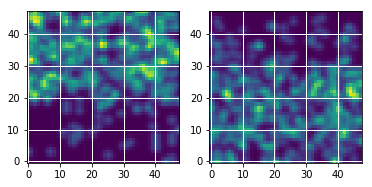

In [146]:
plt.subplot(121)
plt.imshow(ndimage.filters.gaussian_filter(field_image.sum(axis = (2,3)).T, 1.0), origin='lower')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.subplot(122)
plt.imshow(ndimage.filters.gaussian_filter(field_image.sum(axis = (0,1)).T, 1.0), origin='lower')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.show()
plt.subplot(121)
plt.imshow(ndimage.filters.gaussian_filter(field_image.sum(axis = (1,3)).T, 1.0), origin='lower')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.subplot(122)
plt.imshow(ndimage.filters.gaussian_filter(field_image.sum(axis = (0,2)).T, 1.0),  origin='lower')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.show()

In [147]:
import pywt
wavelets = ['bior2.2'] #, 'bior2.4', 'bior2.6', 'bior2.8'] #, 'bior4.4','bior5.5', 'bior6.8']
wav_len = [6, 8, 12, 16]
j = 0 
for wv in wavelets: 
        coeff = pywt.swtn(filtered_ims, wv, level=4)

        coeff_rand = pywt.swtn(random_image, wv, level=4)



In [148]:
coeff[0]['aadd'] = np.exp(4+1)*coeff[0]['aadd']                               
coeff[0]['ddaa'] = np.exp(4+1)*coeff[0]['ddaa']      
coeff[0]['aaaa'] = np.exp(4+1)*coeff[0]['aaaa']
coeff[0]['aaad'] = np.exp(4+1)*coeff[0]['aaad']
coeff[0]['daaa'] = np.exp(4+1)*coeff[0]['daaa']
coeff[0]['adaa'] = np.exp(4+1)*coeff[0]['adaa']
coeff[0]['aada'] = np.exp(4+1)*coeff[0]['aada']

coeff[1]['aadd'] = np.exp(3+1)*coeff[1]['aadd']                               
coeff[1]['ddaa'] = np.exp(3+1)*coeff[1]['ddaa']      
coeff[1]['aaad'] = np.exp(3+1)*coeff[1]['aaad']
coeff[1]['daaa'] = np.exp(3+1)*coeff[1]['daaa']
coeff[1]['adaa'] = np.exp(3+1)*coeff[1]['adaa']
coeff[1]['aada'] = np.exp(3+1)*coeff[1]['aada']

coeff[2]['aadd'] = np.exp(2+1)*coeff[2]['aadd']                               
coeff[2]['ddaa'] = np.exp(2+1)*coeff[2]['ddaa']      
coeff[2]['aaad'] = np.exp(2+1)*coeff[2]['aaad']
coeff[2]['daaa'] = np.exp(2+1)*coeff[2]['daaa']
coeff[2]['adaa'] = np.exp(2+1)*coeff[2]['adaa']
coeff[2]['aada'] = np.exp(2+1)*coeff[2]['aada']

coeff[3]['aadd'] = np.exp(1+1)*coeff[3]['aadd']                               
coeff[3]['ddaa'] = np.exp(1+1)*coeff[3]['ddaa']      
coeff[3]['aaad'] = np.exp(1+1)*coeff[3]['aaad']
coeff[3]['daaa'] = np.exp(1+1)*coeff[3]['daaa']
coeff[3]['adaa'] = np.exp(1+1)*coeff[3]['adaa']
coeff[3]['aada'] = np.exp(1+1)*coeff[3]['aada']

coeff_rand[0]['aadd'] = np.exp(4+1)*coeff_rand[0]['aadd']                               
coeff_rand[0]['ddaa'] = np.exp(4+1)*coeff_rand[0]['ddaa']      
coeff_rand[0]['aaaa'] = np.exp(4+1)*coeff_rand[0]['aaaa']
coeff_rand[0]['aaad'] = np.exp(4+1)*coeff_rand[0]['aaad']
coeff_rand[0]['daaa'] = np.exp(4+1)*coeff_rand[0]['daaa']
coeff_rand[0]['adaa'] = np.exp(4+1)*coeff_rand[0]['adaa']
coeff_rand[0]['aada'] = np.exp(4+1)*coeff_rand[0]['aada']

coeff_rand[1]['aadd'] = np.exp(3+1)*coeff_rand[1]['aadd']                               
coeff_rand[1]['ddaa'] = np.exp(3+1)*coeff_rand[1]['ddaa']      
coeff_rand[1]['aaad'] = np.exp(3+1)*coeff_rand[1]['aaad']
coeff_rand[1]['daaa'] = np.exp(3+1)*coeff_rand[1]['daaa']
coeff_rand[1]['adaa'] = np.exp(3+1)*coeff_rand[1]['adaa']
coeff_rand[1]['aada'] = np.exp(3+1)*coeff_rand[1]['aada']

coeff_rand[2]['aadd'] = np.exp(2+1)*coeff_rand[2]['aadd']                               
coeff_rand[2]['ddaa'] = np.exp(2+1)*coeff_rand[2]['ddaa']      
coeff_rand[2]['aaad'] = np.exp(2+1)*coeff_rand[2]['aaad']
coeff_rand[2]['daaa'] = np.exp(2+1)*coeff_rand[2]['daaa']
coeff_rand[2]['adaa'] = np.exp(2+1)*coeff_rand[2]['adaa']
coeff_rand[2]['aada'] = np.exp(2+1)*coeff_rand[2]['aada']

coeff_rand[3]['aadd'] = np.exp(1+1)*coeff_rand[3]['aadd']                               
coeff_rand[3]['ddaa'] = np.exp(1+1)*coeff_rand[3]['ddaa']      
coeff_rand[3]['aaad'] = np.exp(1+1)*coeff_rand[3]['aaad']
coeff_rand[3]['daaa'] = np.exp(1+1)*coeff_rand[3]['daaa']
coeff_rand[3]['adaa'] = np.exp(1+1)*coeff_rand[3]['adaa']
coeff_rand[3]['aada'] = np.exp(1+1)*coeff_rand[3]['aada']


[[[[-4.98046875e-02 -1.24511719e-02  6.22558594e-03 ...  1.24511719e-02
     8.71582031e-02  1.24511719e-02]
   [-1.31225586e-02 -3.28063965e-03  1.64031982e-03 ...  3.28063965e-03
     2.29644775e-02  3.28063965e-03]
   [-4.02832031e-03 -1.00708008e-03  5.03540039e-04 ...  1.00708008e-03
     7.04956055e-03  1.00708008e-03]
   ...
   [-5.21850586e-02 -1.30462646e-02  6.52313232e-03 ...  1.30462646e-02
     9.13238525e-02  1.30462646e-02]
   [-6.34765625e-02 -1.58691406e-02  7.93457031e-03 ...  1.58691406e-02
     1.11083984e-01  1.58691406e-02]
   [-1.02539062e-01 -2.56347656e-02  1.28173828e-02 ...  2.56347656e-02
     1.79443359e-01  2.56347656e-02]]

  [[-1.13281250e-01 -2.83203125e-02  1.41601563e-02 ...  2.83203125e-02
     1.98242188e-01  2.83203125e-02]
   [-3.22265625e-02 -8.05664062e-03  4.02832031e-03 ...  8.05664062e-03
     5.63964844e-02  8.05664062e-03]
   [-9.76562500e-03 -2.44140625e-03  1.22070313e-03 ...  2.44140625e-03
     1.70898437e-02  2.44140625e-03]
   ...
   

In [149]:


filtered_ims = pywt.iswtn(coeff, wv)

random_ims = pywt.iswtn(coeff_rand, wv)



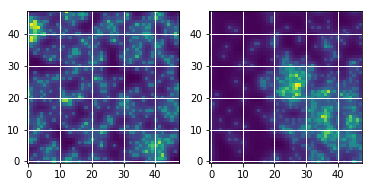

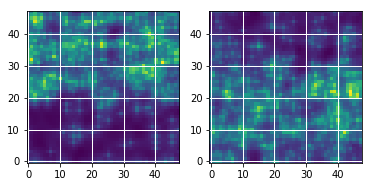

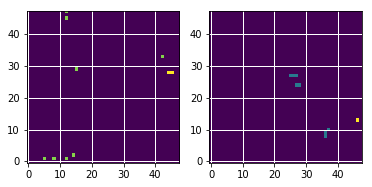

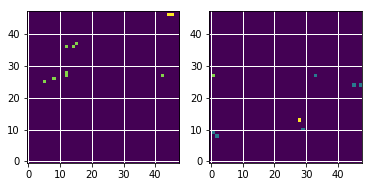

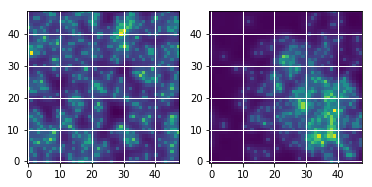

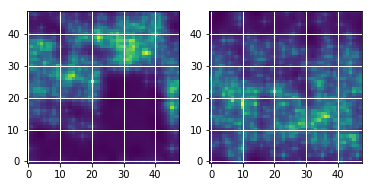

In [150]:
plt.subplot(121)
plt.imshow((filtered_ims.sum(axis = (2,3)).T), origin='lower')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.subplot(122)
plt.imshow(filtered_ims.sum(axis = (0,1)).T, origin='lower')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.show()
plt.subplot(121)
plt.imshow((filtered_ims.sum(axis = (1,3)).T), origin='lower')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.subplot(122)
plt.imshow((filtered_ims.sum(axis = (0,2)).T),  origin='lower')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.show()



#mask = filtered_ims < np.mean(random_ims) + 60*np.std(random_ims)
#filtered_ims[mask] = 0 

#mask = np.invert(mask)
filtered_ims = (filtered_ims-np.mean(random_ims))/np.std(random_ims)
un = np.unique(filtered_ims)
mm = max(un[len(un)-10], 50)
mask = filtered_ims < mm
filtered_ims[mask] = 0 


plt.subplot(121)
plt.imshow((filtered_ims.sum(axis = (2,3)).T), origin='lower')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.subplot(122)
plt.imshow(filtered_ims.sum(axis = (0,1)).T, origin='lower')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.show()
plt.subplot(121)
plt.imshow((filtered_ims.sum(axis = (1,3)).T), origin='lower')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.subplot(122)
plt.imshow((filtered_ims.sum(axis = (0,2)).T),  origin='lower')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.show()

plt.subplot(121)
plt.imshow((random_ims.sum(axis = (2,3)).T), origin='lower')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.subplot(122)
plt.imshow(random_ims.sum(axis = (0,1)).T, origin='lower')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.show()
plt.subplot(121)
plt.imshow((random_ims.sum(axis = (1,3)).T), origin='lower')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.subplot(122)
plt.imshow((random_ims.sum(axis = (0,2)).T),  origin='lower')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.show()



In [151]:
def find_labels2(thresh):
    temp_thresh = np.copy(thresh)
    mask = temp_thresh != 0 
 #   temp_thresh = thresh 
    temp_thresh[mask] = 255 
    labels = measure.label(temp_thresh, neighbors=8, background=0)
    mask = np.zeros(thresh.shape, dtype="uint8")
    for label in np.unique(labels):

        if label == 0:
            continue
        
        labelMask = np.zeros(thresh.shape, dtype="uint8")
        labelMask[labels == label] = 255
        numPixels = cv2.countNonZero(labelMask)
        
 #       if numPixels >= 9:
        mask = cv2.add(mask, labelMask)
    return mask

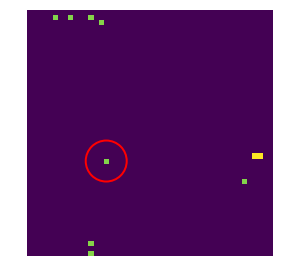

In [164]:
import cv2
from skimage.color import rgb2gray
from imutils import contours
from skimage import measure
import numpy as np
import argparse
import imutils
rd = filtered_ims.sum(axis = (2,3)).T
mask = find_labels2(rd)
cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = contours.sort_contours(cnts)[0]
# loop over the contours
fig, ax = plt.subplots()
#ax = axes.ravel()



#for idx, (blobs, color, title) in enumerate(sequence):
#    ax[idx].set_title(title)
blobs = [] 
ax.imshow(rd)
for (i, c) in enumerate(cnts):
    # draw the bright spot on the image
   
    ((cX, cY), radius) = cv2.minEnclosingCircle(c)
    if (radius < 6):
        radius = 6
    if(cX > 12 and cX < 84 and cY > 12 and cY < 84):
        blobs.append([cX, cY, radius])
        c = plt.Circle((cX, cY), radius, color='red', linewidth=2, fill=False)
        ax.add_patch(c)
    #   c.plot(ax=ax,color='red')
    ax.set_axis_off()

plt.tight_layout()
plt.show()


    #    cv2.circle(rd, (int(cX), int(cY)), int(radius), (0, 0, 255), 3)
#    cv2.putText(rd, "#{}".format(i + 1), (x, y - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
 
# show the output image
#cv2.imshow(rd)
#cv2.waitKey(0)

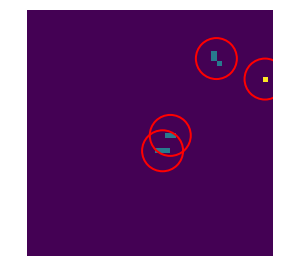

In [165]:
prpd = filtered_ims.sum(axis = (0,1)).T
mask = find_labels2(prpd)
cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = contours.sort_contours(cnts)[0]
# loop over the contours
fig, ax = plt.subplots()
#ax = axes.ravel()



#for idx, (blobs, color, title) in enumerate(sequence):
#    ax[idx].set_title(title)
blobs2 = [] 
ax.imshow(prpd)
for (i, c) in enumerate(cnts):
    # draw the bright spot on the image
    ((cX, cY), radius) = cv2.minEnclosingCircle(c)
    if (radius < 6):
        radius = 6
    blobs2.append([cX, cY, radius])
    c = plt.Circle((cX, cY), radius, color='red', linewidth=2, fill=False)
    ax.add_patch(c)
    #   c.plot(ax=ax,color='red')
    ax.set_axis_off()

plt.tight_layout()
plt.show()



In [166]:

data = pd.read_hdf('/oak/stanford/orgs/kipac/edarragh/gaiadr2.hdf5', loc) 


#ra = (store['RA_50_55/DEC_-55_-50']['ra'])
#dec = (store['RA_50_55/DEC_-55_-50']['dec'])
#pmra = (store['RA_50_55/DEC_-55_-50']['pmra'])
#pmdec = (store['RA_50_55/DEC_-55_-50']['pmdec'])
#parallax = (store['RA_50_55/DEC_-55_-50']['parallax'])
mask = data['ra'] > median_ra - 1 
mask1 = data['ra'] < median_ra  + 1. 
mask2 = data['dec'] > median_dec - 1. 
mask3 = data['dec'] < median_dec + 1.
mask4 = data['parallax'] < 0.1

data = data[mask & mask1 & mask2 & mask3 & mask4]
#dec = dec[mask & mask1 & mask2 & mask3 & mask4]
#pmra = pmra[mask & mask1 & mask2 & mask3 & mask4]
#pmdec = pmdec[mask & mask1 & mask2 & mask3 & mask4]
#parallax = parallax[mask & mask1 & mask2 & mask3 & mask4]
mask = (np.invert(np.isnan(data['parallax'])))
mask1 = (np.invert(np.isnan(data['ra'])))
mask2 = (np.invert(np.isnan(data['dec'])))
mask3 = (np.invert(np.isnan(data['pmra'])))
mask4 = (np.invert(np.isnan(data['pmdec'])))

data = data[mask & mask1 & mask2 & mask3 & mask4]
#dec = dec[mask & mask1 & mask2 & mask3 & mask4]
#pmra = pmra[mask & mask1 & mask2 & mask3 & mask4]
#pmdec = pmdec[mask & mask1 & mask2 & mask3 & mask4]
#parallax = parallax[mask & mask1 & mask2 & mask3 & mask4]
print(len(data['ra'].values))
#store.close()

790


In [167]:
stars = []
for blob in blobs: 
    cut_idx = ((data['ra']-(2./96*(blob[0]-48)+median_ra))**2 + (data['dec']-(2./96*(blob[1]-48)+median_dec))**2) < (2./96*blob[2])**2
   # print(len(dgaia_short[cut_idx]))
    stars.append(data[cut_idx])
   # print(len(data[cut_idx]))


clusters = [] 
for blob in blobs2: 
    for star in stars: 
        cut_idx = ((star['pmra']-(8./96*(blob[0]-48)))**2 + (star['pmdec']-(8./96*(blob[1]-48)))**2) < (8./96*blob[2])**2
        #print(len(star[cut_idx]))
        clusters.append(star[cut_idx])
#clusters= stars
print(len(clusters[0]))

1


In [168]:


import networkx 
from networkx.algorithms.components.connected import connected_components


def to_graph(l):
    G = networkx.Graph()
    for part in l:
        # each sublist is a bunch of nodes
        G.add_nodes_from(part['ra'])
        # it also imlies a number of edges:
        G.add_edges_from(to_edges(part['ra']))
    return G

def to_edges(l):
    """ 
        treat `l` as a Graph and returns it's edges 
        to_edges(['a','b','c','d']) -> [(a,b), (b,c),(c,d)]
    """
    it = iter(l)
    last = next(it)

    for current in it:
        yield last, current
        last = current    

G = to_graph(clusters)
p = (connected_components(G))

clusters2 = [] 
for i in p:
    list_temp = list(i)
    mask = data['ra'].isin(list_temp)
    stars = data[mask]
    clusters2.append(stars)
    

clusters2.sort(key=len)
clusters2 = clusters2[::-1]
print(len(clusters2))

2


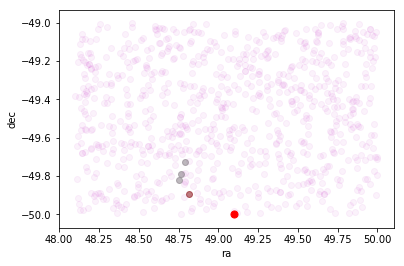

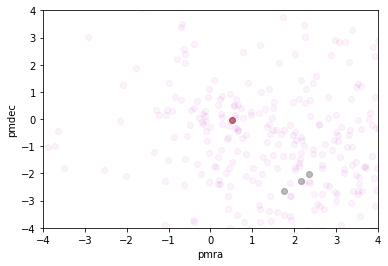

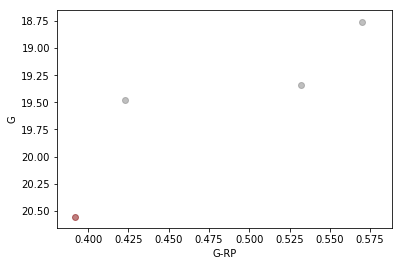

1
2


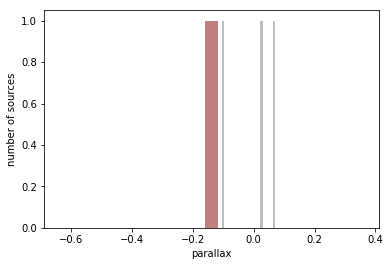

1


In [169]:
color = ['grey', 'maroon', 'royalblue', 'orange', 'darkorchid', 'red', 'yellow', 'green', 'blue']

color_index = 0 
plt.scatter(data['ra'].values, data['dec'].values, c='m',alpha=0.05)
for cluster in clusters2: 
    if (len(cluster)>0):
        plt.scatter(cluster['ra'].values, cluster['dec'].values, c=color[color_index],alpha=0.5)
        color_index = color_index + 1 

plt.scatter(median_ra, median_dec, color='red', s=50)        
plt.xlabel('ra')
plt.ylabel('dec')
plt.show()

color_index = 0 
plt.scatter(data['pmra'].values, data['pmdec'].values, c='m',alpha=0.05)
for cluster in clusters2: 
    if (len(cluster)>0):   
       # plt.scatter(data['pmra'].values, data['pmdec'].values, c='m',alpha=0.005)
        plt.scatter(cluster['pmra'].values, cluster['pmdec'].values, c=color[color_index],alpha=0.5)
        color_index = color_index + 1 
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel('pmra')
plt.ylabel('pmdec')
plt.show()

color_index = 0 
for cluster in clusters2: 
    if (len(cluster)>0):   
        plt.scatter((cluster['g_rp'].values), cluster['phot_g_mean_mag'].values, c=color[color_index],alpha=0.5)
        color_index = color_index + 1 
plt.xlabel('G-RP')
plt.ylabel('G')
plt.gca().invert_yaxis()
plt.show()


#plt.scatter(dgaia_short['BPmag'].values-dgaia_short['RPmag'].values,((1/dgaia_short['parallax'].values)), c='m',alpha=0.05)
color_index = 0
for cluster in clusters2: 
    if (len(cluster)>0):    
        plt.hist(cluster['parallax'], bins=25, color=color[color_index], alpha=0.5)
        color_index = color_index + 1 
        print(color_index)
plt.xlabel('parallax')
plt.ylabel('number of sources')
plt.show()

#mask = clusters[1]['parallax'] > 0 
#print(1./np.mean(clusters[1]['parallax'][mask]))

i = 0

print(len(clusters[0]))

Its just garbage below here

In [37]:
#plt.scatter(dgaia_short['ra'].values, dgaia_short['dec'].values, c='m',alpha=0.005)
for cluster in clusters2: 
#ididx = dgaia_all['id'] != dg
    if (len(cluster)>5):
        plt.scatter(data['ra'].values, data['dec'].values, c='m',alpha=0.005)
        plt.scatter(cluster['ra'].values, cluster['dec'].values, c='b',alpha=0.5)
        plt.scatter(median_ra, median_dec, color='r', s=50)
        plt.xlabel('ra')
        plt.ylabel('dec')
        plt.show()

#plt.scatter(dgaia_short['pmra'].values, dgaia_short['pmdec'].values, c='b',alpha=0.005)
#for cluster in clusters: 
#    if (len(cluster)>15):   
        plt.scatter(data['pmra'].values, data['pmdec'].values, c='b',alpha=0.005)
        plt.scatter(cluster['pmra'].values, cluster['pmdec'].values, c='b',alpha=0.5)
        plt.xlim([-4,4])
        plt.ylim([-4,4])
        plt.xlabel('pmra')
        plt.ylabel('pmdec')
        plt.show()

#for cluster in clusters: 
#    if (len(cluster)>6):    
        plt.scatter((cluster['bp_rp'].values), cluster['phot_g_mean_mag'].values, c='b',alpha=0.5)
        plt.xlabel('BP-RP')
        plt.ylabel('G')
        plt.gca().invert_yaxis()
        plt.show()


#plt.scatter(dgaia_short['BPmag'].values-dgaia_short['RPmag'].values,((1/dgaia_short['parallax'].values)), c='m',alpha=0.05)
#for cluster in clusters: 
#    if (len(cluster)>6):    
        plt.hist(cluster['parallax'], bins=25)
        plt.xlabel('parallax')
        plt.ylabel('number of sources')
        plt.show()

mask = clusters[1]['parallax'] > 0 
print(1./np.mean(clusters[1]['parallax'][mask]))

nan


In [108]:
print(un[len(un)-5:])

[81.82100915 84.77814105 84.91649598 85.50572515 87.41353057]


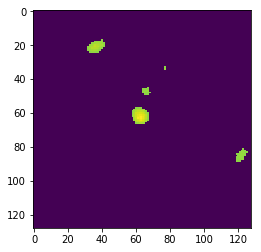

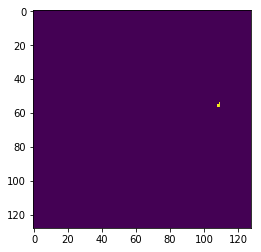

In [118]:

rpra = rpr.sum(axis=0)
dpda = dpd.sum(axis=0)
rprb = rpr.sum(axis=1)
dpdb = dpd.sum(axis=1)

for i in range(rd[0].shape[0]):
    rd[i][rpra==0]     = 0 
    rd[:,i][dpda==0]   = 0 
    prpd[i][rprb==0]     = 0 
    prpd[:,i][dpdb==0]   = 0 
    
plt.imshow(rd)
plt.show()
plt.imshow(prpd)
plt.show()

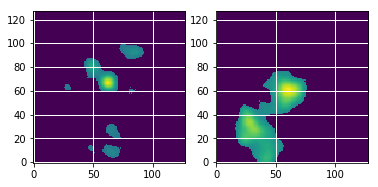

In [40]:
plt.subplot(121)
plt.imshow(rd, origin='lower')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.subplot(122)
plt.imshow(prpd, origin='lower')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.show()

In [76]:

rd = find_labels(coeff_tot)
prpd = find_labels((coeff_pm_tot)) 
rpr = find_labels((coeff_ra_tot))
dpd = find_labels((coeff_dec_tot))
plt.imshow(rd)
plt.imshow(prpd)

plt.imshow(rd)
plt.imshow(prpd)

#rd = find_labels(coeff_tot[0]['aa'] + coeff_tot[1]['aa'] + coeff_tot[0]['ad'] + coeff_tot[0]['da'])
#prpd = find_labels(coeff_pm_tot[0]['aa']+coeff_pm_tot[1]['aa']+coeff_pm_tot[0]['ad'] + coeff_pm_tot[0]['da'])
#rpr = find_labels(coeff_ra_tot[1]['ad']+coeff_ra_tot[1]['da']+coeff_ra_tot[2]['aa']+coeff_ra_tot[0]['ad']+ coeff_ra_tot[0]['da'])
#dpd = find_labels(coeff_dec_tot[1]['ad']+coeff_dec_tot[1]['da']+coeff_dec_tot[2]['aa']+coeff_dec_tot[0]['ad'] + coeff_dec_tot[0]['da'])

NameError: name 'coeff_tot' is not defined

In [101]:

image_gray = rgb2gray(prpd)
blobs_doh2 = blob_doh(image_gray, min_sigma=10, max_sigma=50, threshold=0.05)
blobs_doh3 = blob_doh(image_gray, min_sigma=10, max_sigma=50, threshold=0.02)
if (len(blobs_doh2) < len(blobs_doh3)):
    blobs_doh2 = blobs_doh3
#blobs_list = [blobs_log, blobs_dog, blobs_doh]
#blobs_list = [blobs_doh]
#colors = [ 'red']
#titles = ['Determinant of Hessian']
#sequence = zip(blobs_list, colors, titles)

fig, ax = plt.subplots()
#ax = axes.ravel()



#for idx, (blobs, color, title) in enumerate(sequence):
#    ax[idx].set_title(title)
ax.imshow(prpd)
for blob in blobs_doh2:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax.add_patch(c)
    #   c.plot(ax=ax,color='red')
    ax.set_axis_off()

plt.tight_layout()
plt.show()

NameError: name 'blob_doh' is not defined

In [ ]:
from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray


import matplotlib.pyplot as plt


image = rd
image_gray = rgb2gray(rd)

#blobs_log = blob_log(image_gray, min_sigma=8, max_sigma=15, threshold=0.03)

# Compute radii in the 3rd column.
#blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

#blobs_dog = blob_dog(image_gray, min_sigma=4, max_sigma=30)
#blobs_dog = [[0,110, 10]]

blobs_doh = blob_doh(image_gray, min_sigma=10, max_sigma=40, threshold=0.02)

#blobs_list = [blobs_log, blobs_dog, blobs_doh]
#blobs_list = [blobs_doh]
#colors = [ 'red']
#titles = ['Determinant of Hessian']
#sequence = zip(blobs_list, colors, titles)

fig, ax = plt.subplots()
#ax = axes.ravel()



#for idx, (blobs, color, title) in enumerate(sequence):
#    ax[idx].set_title(title)
ax.imshow(rd)
for blob in blobs_doh:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax.add_patch(c)
    #   c.plot(ax=ax,color='red')
    ax.set_axis_off()

plt.tight_layout()
plt.show()

pictori


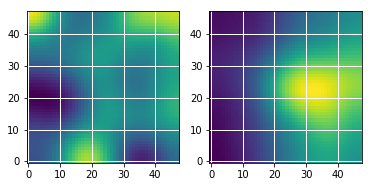

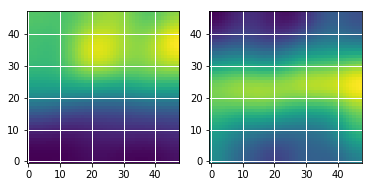

ValueError: start_level must be less than 4.

In [218]:
import pywt


print(name)
plt.subplot(121)
plt.imshow(ndimage.filters.gaussian_filter(filtered_ims.sum(axis = (2,3)).T, 6.0), origin='lower')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.subplot(122)
plt.imshow(ndimage.filters.gaussian_filter(filtered_ims.sum(axis = (0,1)).T, 6.0), origin='lower')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.show()
plt.subplot(121)
plt.imshow(ndimage.filters.gaussian_filter(filtered_ims.sum(axis = (1,3)).T, 6.0), origin='lower')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.subplot(122)
plt.imshow(ndimage.filters.gaussian_filter(filtered_ims.sum(axis = (0,2)).T, 6.0),  origin='lower')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.show()

sigma1 = np.std(filtered_ims.sum(axis = (2,3)).T)
sigma2 = np.std(filtered_ims.sum(axis = (0,1)).T)
sigma3 = np.std(filtered_ims.sum(axis = (1,3)).T)
sigma4 = np.std(filtered_ims.sum(axis = (0,2)).T)

wavelets = ['bior2.2', 'bior2.4', 'bior2.6', 'bior2.8'] #, 'bior4.4','bior5.5', 'bior6.8']
wav_len = [6, 8, 12, 16]
j = 0 
for i in range(1):
    for wv in wavelets: 
        coeff = pywt.swtn(filtered_ims.sum(axis = (2,3)).T, wv, level=6)
        coeff_pm = pywt.swtn(filtered_ims.sum(axis = (0,1)).T, wv, level=6)
        coeff_ra = pywt.swtn(filtered_ims.sum(axis = (1,3)).T, wv, level=6)
        coeff_dec = pywt.swtn(filtered_ims.sum(axis = (0,2)).T, wv, level=6)

        coeff_rand = pywt.swtn(random_image.sum(axis = (2,3)).T, wv, level=6)
        coeff_pm_rand = pywt.swtn(random_image.sum(axis = (0,1)).T, wv, level=6)
        coeff_ra_rand = pywt.swtn(random_image.sum(axis = (1,3)).T, wv, level=6)
        coeff_dec_rand = pywt.swtn(random_image.sum(axis = (0,2)).T, wv, level=6)        

    
        print(wv)

   #     thresh = 3.0

   #     print(np.max(coeff[0]['aa']))
 #       mask = coeff[0]['aa'] < thresh* sigma_rd*np.std(coeff_rand[0]['aa']) + np.mean(coeff_rand[0]['aa'])#np.sqrt(np.std(coeff_rand[0]['ad'])**2 + np.std(coeff_rand[0]['da'])**2 + np.std(coeff_rand[0]['dd'])**2 + np.std(coeff_rand[1]['ad'])**2 + np.std(coeff_rand[1]['da'])**2 + np.std(coeff_rand[1]['dd'])**2) #3*thresh*sigma_rd*np.std(coeff_rand[0]['aa']) 
 #       coeff[0]['aa'][mask] = 0 
 #       mask = coeff_pm[0]['aa'] < thresh*sigma_prpd*np.std(coeff_pm_rand[0]['aa'])+ np.mean(coeff_pm_rand[0]['aa'])#np.sqrt(np.std(coeff_pm_rand[0]['ad'])**2 + np.std(coeff_pm_rand[0]['da'])**2 + np.std(coeff_pm_rand[0]['dd'])**2 + np.std(coeff_pm_rand[1]['ad'])**2 + np.std(coeff_pm_rand[1]['da'])**2 + np.std(coeff_pm_rand[1]['dd'])**2) #3*thresh*sigma_prpd*np.std(coeff_pm_rand[0]['aa']) 
  #      coeff_pm[0]['aa'][mask] = 0 
  #      mask = coeff_ra[0]['ad']  < thresh*sigma_rpr*np.std(coeff_ra_rand[0]['ad'] + coeff_ra_rand[0]['da'] + coeff_ra_rand[0]['dd'])
  #      coeff_ra[0]['ad'][mask] = 0     
  #      mask = coeff_ra[0]['da']   <  thresh*sigma_rpr*np.std(coeff_ra_rand[0]['da'] + coeff_ra_rand[0]['ad'] + coeff_ra_rand[0]['dd']) #(np.percentile(coeff_ra[0]['da'], 75) - np.percentile(coeff_ra[0]['da'], 25))*thresh+np.median(coeff_ra[0]['da'])   
  #      coeff_ra[0]['da'][mask] = 0 #(np.percentile(coeff_dec[0]['ad'], 75) - np.percentile(coeff_dec[0]['ad'], 25))*thresh+np.median(coeff_dec[0]['ad'])
  #      mask = coeff_dec[0]['ad']  < thresh* sigma_dpd*np.std(coeff_dec_rand[0]['ad'] + coeff_dec_rand[0]['da'] + coeff_dec_rand[0]['dd'])
  #      coeff_dec[0]['ad'][mask]= 0     
  #      mask = coeff_dec[0]['da']  < thresh*sigma_dpd* np.std(coeff_dec_rand[0]['da'] + coeff_dec_rand[0]['ad'] + coeff_dec_rand[0]['dd']) #thresh*sigma_dpd*np.std(coeff_dec_rand[0]['da']) #(np.percentile(coeff_dec[0]['da'], 75) - np.percentile(coeff_dec[0]['da'], 25))*thresh+np.median(coeff_dec[0]['da'])
   #     coeff_dec[0]['da'][mask]= 0


      #  mask =  (coeff[0]['ad'] + coeff[0]['da']) < 0.0
      #  new_coeff = coeff[0]['ad'] + coeff[0]['da']
        
      #  new_coeff[mask] = 0
      #  mask = np.invert(mask)
      #  new_coeff[mask] = 1
        
      #  new_coeff2 = canny(new_coeff, wav_len[j])
        
                                          
       # mask = ndimage.filters.gaussian_filter(1000*new_coeff2, 2.0) > 0                     
       # coeff[0]['ad'][mask] =1000*coeff[0]['ad'][mask]                                     
       # coeff[0]['da'][mask] = 1000*coeff[0]['da'][mask]  
       # coeff[0]['dd'][mask]= 1000*coeff[0]['dd'][mask] 
       # coeff[0]['aa'][mask] = 1000*coeff[0]['aa'][mask]
        
 #       mask = np.abs(coeff[0]['ad']   ) > 1.5*np.std(coeff_rand[0]['ad'] )
 #       coeff[0]['ad'][mask] = np.exp(6+1)*coeff[0]['ad'][mask]  
 #       mask = np.abs(coeff[0]['da']   ) > 1.5*np.std(coeff_rand[0]['da'] )
 #       coeff[0]['da'][mask] = np.exp(6+1)*coeff[0]['da'][mask]
 #       mask = np.abs(coeff[0]['dd']   ) > 1.5*np.std(coeff_rand[0]['dd'] )
 #       coeff[0]['dd'][mask] = np.exp(6+1)*coeff[0]['dd'][mask]
 #       coeff[0]['aa'] = np.exp(6+1)*coeff[0]['aa']
    
 #       mask = np.abs(coeff_rand[0]['ad']  ) > 1.5*np.std(coeff_rand[0]['ad'] )
 #       coeff_rand[0]['ad'][mask] = np.exp(6+1)*coeff_rand[0]['ad'][mask] 
 #       mask = np.abs(coeff_rand[0]['da']  ) > 1.5*np.std(coeff_rand[0]['da'] )
 #       coeff_rand[0]['da'][mask] = np.exp(6+1)*coeff_rand[0]['da'][mask]  
 #       mask = np.abs(coeff_rand[0]['dd']  ) > 1.5*np.std(coeff_rand[0]['dd'] )
 #       coeff_rand[0]['dd'][mask] = np.exp(6+1)*coeff_rand[0]['dd'][mask] 
 #       coeff_rand[0]['aa'] = np.exp(6+1)*coeff_rand[0]['aa']
        
  #      mask = np.abs(coeff[1]['ad']) > 1.5*np.std(coeff_rand[1]['ad'] )
  #      coeff[1]['ad'][mask] = np.exp(5+1)*coeff[1]['ad'][mask]                                 
  #      mask = np.abs(coeff[1]['da']) > 1.5*np.std(coeff_rand[1]['da'] )
  #      coeff[1]['da'][mask] = np.exp(5+1)*coeff[1]['da'][mask]   
  #      mask = np.abs(coeff[1]['dd']) > 1.5*np.std(coeff_rand[1]['dd'] )
  #      coeff[1]['dd'][mask] = np.exp(5+1)*coeff[1]['dd'][mask]
        
  #      mask = (coeff[2]['ad']) > 1.5*np.std(coeff_rand[2]['ad'])
  #      coeff[2]['ad'][mask] = np.exp(4+1)*coeff[2]['ad'][mask]   
  #      mask = (coeff[2]['da']) > 1.5*np.std(coeff_rand[2]['da'])
  #      coeff[2]['da'][mask] = np.exp(4+1)*coeff[2]['da'][mask] 
  #      mask = (coeff[2]['dd']) > 1.5*np.std(coeff_rand[2]['dd'])
  #      coeff[2]['dd'][mask] = np.exp(4+1)*coeff[2]['dd'][mask]
            
  #      mask = np.abs(coeff_rand[1]['ad']) > 1.5*np.std(coeff_rand[1]['ad'] )
  #      coeff_rand[1]['ad'][mask] = np.exp(5+1)*coeff_rand[1]['ad'][mask]   
  #      mask = np.abs(coeff_rand[1]['da']) > 1.5*np.std(coeff_rand[1]['da'] )
  #      coeff_rand[1]['da'][mask] = np.exp(5+1)*coeff_rand[1]['da'][mask]
  #      mask = np.abs(coeff_rand[1]['dd']) > 1.5*np.std(coeff_rand[1]['dd'] )
  #      coeff_rand[1]['dd'][mask] = np.exp(5+1)*coeff_rand[1]['dd'][mask]

 #       mask = (coeff_rand[2]['ad'] ) > 1.5*np.std(coeff_rand[2]['ad'] )   
 #       coeff_rand[2]['ad'][mask] = np.exp(4+1)*coeff_rand[2]['ad'][mask]   
 #       mask = (coeff_rand[2]['da'] ) > 1.5*np.std(coeff_rand[2]['da'] )
 #       coeff_rand[2]['da'][mask] = np.exp(4+1)*coeff_rand[2]['da'][mask]
 #       mask = (coeff_rand[2]['dd'] ) > 1.5*np.std(coeff_rand[2]['dd'] )
 #       coeff_rand[2]['dd'][mask] = np.exp(4+1)*coeff_rand[2]['dd'][mask]


        mask = np.abs(coeff[0]['ad']  + coeff[0]['da']  ) > 1.5*np.std(coeff_rand[0]['ad']  + coeff_rand[0]['da'])
        coeff[0]['ad'] = np.exp(6+1)*coeff[0]['ad']                               
        coeff[0]['da'] = np.exp(6+1)*coeff[0]['da']      
        coeff[0]['dd'] = np.exp(6+1)*coeff[0]['dd']
        coeff[0]['aa'] = np.exp(6+1)*coeff[0]['aa']
    
        mask = np.abs(coeff_rand[0]['ad']  + coeff_rand[0]['da']  ) > 1.5*np.std(coeff_rand[0]['ad']  + coeff_rand[0]['da'])
        coeff_rand[0]['ad'] = np.exp(6+1)*coeff_rand[0]['ad']                                   
        coeff_rand[0]['da'] = np.exp(6+1)*coeff_rand[0]['da']
        coeff_rand[0]['dd'] = np.exp(6+1)*coeff_rand[0]['dd']
        coeff_rand[0]['aa'] = np.exp(6+1)*coeff_rand[0]['aa']
        
        mask = np.abs(coeff[1]['ad']  + coeff[1]['da']  ) > 1.5*np.std(coeff_rand[1]['ad']  +coeff_rand[1]['da']  )
        coeff[1]['ad'] = np.exp(5+1)*coeff[1]['ad']                             
        coeff[1]['da'] = np.exp(5+1)*coeff[1]['da']  
        coeff[1]['dd'] = np.exp(5+1)*coeff[1]['dd']
        
        mask = np.abs(coeff[2]['ad']  + coeff[2]['da']  ) > 1.5*np.std(coeff_rand[2]['ad']  +coeff_rand[2]['da']  )
        coeff[2]['ad'] = np.exp(4+1)*coeff[2]['ad']                             
        coeff[2]['da'] = np.exp(4+1)*coeff[2]['da']  
        coeff[2]['dd'] = np.exp(4+1)*coeff[2]['dd']
            
        mask = np.abs(coeff_rand[1]['ad']  + coeff_rand[1]['da']  ) > 1.5*np.std(coeff_rand[1]['ad']  +coeff_rand[1]['da']  )
        coeff_rand[1]['ad'] = np.exp(5+1)*coeff_rand[1]['ad']                                   
        coeff_rand[1]['da'] = np.exp(5+1)*coeff_rand[1]['da']
        coeff_rand[1]['dd'] = np.exp(5+1)*coeff_rand[1]['dd']

        mask = np.abs(coeff_rand[2]['ad']  + coeff_rand[2]['da']  ) > 1.5*np.std(coeff_rand[2]['ad']  +coeff_rand[2]['da']  )
        coeff_rand[2]['ad'] = np.exp(4+1)*coeff_rand[2]['ad']                                 
        coeff_rand[2]['da'] = np.exp(4+1)*coeff_rand[2]['da']
        coeff_rand[2]['dd'] = np.exp(4+1)*coeff_rand[2]['dd']    

#        coeff[3]['ad'] = np.exp(3+1)*coeff[3]['ad']                             
#        coeff[3]['da'] = np.exp(3+1)*coeff[3]['da']  
#        coeff[3]['dd'] = np.exp(3+1)*coeff[3]['dd']

#        coeff_rand[3]['ad'] = np.exp(3+1)*coeff_rand[3]['ad']                                 
#        coeff_rand[3]['da'] = np.exp(3+1)*coeff_rand[3]['da']
#        coeff_rand[3]['dd'] = np.exp(3+1)*coeff_rand[3]['dd'] 
        
        mask =  (coeff_pm[0]['ad'] + coeff_pm[0]['da']) < 0.0
        new_coeff = coeff_pm[0]['ad'] + coeff_pm[0]['da']
        
        new_coeff[mask] = 0
        mask = np.invert(mask)
        new_coeff[mask] = 1
        
        new_coeff2 = canny(new_coeff, wav_len[j])
        
        
        mask =  (coeff_pm[1]['ad'] + coeff_pm[1]['da']) < 0.0
        new_coeff = coeff_pm[1]['ad'] + coeff_pm[1]['da']
        
        new_coeff[mask] = 0
        mask = np.invert(mask)
        new_coeff[mask] = 1        
        new_coeff2 = canny(new_coeff, wav_len[j])
  

        mask = ndimage.filters.gaussian_filter(1000*new_coeff2, 2.0) > 0                     
        


        mask =  (coeff_ra[0]['ad'] + coeff_ra[0]['da']) < 0.0
        new_coeff = coeff_ra[0]['ad'] + coeff_ra[0]['da']
        
        new_coeff[mask] = 0
        mask = np.invert(mask)
        new_coeff[mask] = 1
        
        new_coeff2 = canny(new_coeff, wav_len[j])
        
                                          
        mask = ndimage.filters.gaussian_filter(1000*new_coeff2, 2.0) > 0                     
        coeff_pm[0]['ad'] = np.exp(6+1)*coeff_pm[0]['ad']                                     
        coeff_pm[0]['da'] = np.exp(6+1)*coeff_pm[0]['da']
        coeff_pm[0]['dd'] = np.exp(6+1)*coeff_pm[0]['dd']        
        coeff_pm[0]['aa'] = np.exp(6+1)*coeff_pm[0]['aa']

        coeff_pm_rand[0]['ad'] = np.exp(6+1)*coeff_pm_rand[0]['ad']                                     
        coeff_pm_rand[0]['da'] = np.exp(6+1)*coeff_pm_rand[0]['da']
        coeff_pm_rand[0]['dd'] = np.exp(6+1)*coeff_pm_rand[0]['dd']        
        coeff_pm_rand[0]['aa'] = np.exp(6+1)*coeff_pm_rand[0]['aa']
        
        mask =  (coeff_ra[1]['ad'] + coeff_ra[1]['da']) < 0.0
        new_coeff = coeff_ra[1]['ad'] + coeff_ra[1]['da']
        
        new_coeff[mask] = 0
        mask = np.invert(mask)
        new_coeff[mask] = 1        
        new_coeff2 = canny(new_coeff, wav_len[j])
  

        mask = ndimage.filters.gaussian_filter(1000*new_coeff2, 2.0) > 0                     
        coeff_pm[1]['ad'] = np.exp(5+1)*coeff_pm[1]['ad']                                
        coeff_pm[1]['da'] = np.exp(5+1)*coeff_pm[1]['da']
        coeff_pm[1]['dd'] = np.exp(5+1)*coeff_pm[1]['dd']
        
        coeff_pm_rand[1]['ad'] = np.exp(5+1)*coeff_pm_rand[1]['ad']                                
        coeff_pm_rand[1]['da'] = np.exp(5+1)*coeff_pm_rand[1]['da']
        coeff_pm_rand[1]['dd'] = np.exp(5+1)*coeff_pm_rand[1]['dd']
        
        
        coeff_pm[2]['ad'] = np.exp(4+1)*coeff_pm[2]['ad']                                    
        coeff_pm[2]['da'] = np.exp(4+1)*coeff_pm[2]['da']
        coeff_pm[2]['dd'] = np.exp(4+1)*coeff_pm[2]['dd']        

        coeff_pm_rand[2]['ad'] = np.exp(4+1)*coeff_pm_rand[2]['ad']                                    
        coeff_pm_rand[2]['da'] = np.exp(4+1)*coeff_pm_rand[2]['da']
        coeff_pm_rand[2]['dd'] = np.exp(4+1)*coeff_pm_rand[2]['dd'] 
  
#        coeff_pm[3]['ad'] = np.exp(3+1)*coeff_pm[3]['ad']                                    
#        coeff_pm[3]['da'] = np.exp(3+1)*coeff_pm[3]['da']
#        coeff_pm[3]['dd'] = np.exp(3+1)*coeff_pm[3]['dd']        

#        coeff_pm_rand[3]['ad'] = np.exp(3+1)*coeff_pm_rand[3]['ad']                                    
#        coeff_pm_rand[3]['da'] = np.exp(3+1)*coeff_pm_rand[3]['da']
#        coeff_pm_rand[3]['dd'] = np.exp(3+1)*coeff_pm_rand[3]['dd'] 
        
        mask =  (coeff_dec[0]['ad'] + coeff_dec[0]['da']) < 0.0
        new_coeff = coeff_dec[0]['ad'] + coeff_dec[0]['da']
        
        new_coeff[mask] = 0
        mask = np.invert(mask)
        new_coeff[mask] = 1
        
        new_coeff2 = canny(new_coeff, wav_len[j])
        mask = ndimage.filters.gaussian_filter(1000*new_coeff2, 2.0) > 0                     
        coeff_ra[0]['ad'] = np.exp(6+1)*coeff_ra[0]['ad']                                 
        coeff_ra[0]['da'] = np.exp(6+1)*coeff_ra[0]['da']
#        coeff_ra[0]['dd'] = np.exp(6+1)*coeff_ra[0]['dd']
        coeff_ra[0]['aa'] = np.exp(6+1)*coeff_ra[0]['aa']

        coeff_ra_rand[0]['ad'] = np.exp(6+1)*coeff_ra_rand[0]['ad']                                 
        coeff_ra_rand[0]['da'] = np.exp(6+1)*coeff_ra_rand[0]['da']
#        coeff_ra_rand[0]['dd'] = np.exp(6+1)*coeff_ra_rand[0]['dd']
        coeff_ra_rand[0]['aa'] = np.exp(6+1)*coeff_ra_rand[0]['aa']
        
        mask =  (coeff_dec[1]['ad'] + coeff_dec[1]['da']) < 0.0
        new_coeff = coeff_dec[1]['ad'] + coeff_dec[1]['da']
        
        new_coeff[mask] = 0
        mask = np.invert(mask)
        new_coeff[mask] = 1        
        new_coeff2 = canny(new_coeff, wav_len[j])
  

        mask = ndimage.filters.gaussian_filter(1000*new_coeff2, 2.0) > 0                     
        coeff_ra[1]['ad'] = np.exp(5+1)*coeff_ra[1]['ad']                                   
        coeff_ra[1]['da'] = np.exp(5+1)*coeff_ra[1]['da']
 #       coeff_ra[1]['dd'] = np.exp(5+1)*coeff_ra[1]['dd']
    
        coeff_ra_rand[1]['ad'] = np.exp(5+1)*coeff_ra_rand[1]['ad']                                   
        coeff_ra_rand[1]['da'] = np.exp(5+1)*coeff_ra_rand[1]['da']
#        coeff_ra_rand[1]['dd'] = np.exp(5+1)*coeff_ra_rand[1]['dd']

        coeff_ra[2]['ad'] = np.exp(4+1)*coeff_ra[2]['ad']                                     
        coeff_ra[2]['da'] = np.exp(4+1)*coeff_ra[2]['da']  
#        coeff_ra[2]['dd'] = np.exp(4+1)*coeff_ra[2]['dd']

        coeff_ra_rand[2]['ad'] = np.exp(4+1)*coeff_ra_rand[2]['ad']                                     
        coeff_ra_rand[2]['da'] = np.exp(4+1)*coeff_ra_rand[2]['da']  
 #       coeff_ra_rand[2]['dd'] = np.exp(4+1)*coeff_ra_rand[2]['dd']       

#        coeff_ra[3]['ad'] = np.exp(3+1)*coeff_ra[3]['ad']                                     
#        coeff_ra[3]['da'] = np.exp(3+1)*coeff_ra[3]['da']  
#        coeff_ra[2]['dd'] = np.exp(4+1)*coeff_ra[2]['dd']

#        coeff_ra_rand[3]['ad'] = np.exp(3+1)*coeff_ra_rand[3]['ad']                                     
#        coeff_ra_rand[3]['da'] = np.exp(3+1)*coeff_ra_rand[3]['da']  
 #       coeff_ra_rand[2]['dd'] = np.exp(4+1)*coeff_ra_rand[2]['dd'] 

        mask = ndimage.filters.gaussian_filter(1000*new_coeff2, 2.0) > 0                     
        coeff_dec[0]['ad'] = np.exp(6+1)*coeff_dec[0]['ad']                                 
        coeff_dec[0]['da'] = np.exp(6+1)*coeff_dec[0]['da']
#        coeff_dec[0]['dd'] = np.exp(6+1)*coeff_dec[0]['dd']
        coeff_dec[0]['aa'] = np.exp(6+1)*coeff_dec[0]['aa']

        coeff_dec_rand[0]['ad'] = np.exp(6+1)*coeff_dec_rand[0]['ad']                                 
        coeff_dec_rand[0]['da'] = np.exp(6+1)*coeff_dec_rand[0]['da']
#        coeff_dec_rand[0]['dd'] = np.exp(6+1)*coeff_dec_rand[0]['dd']
        coeff_dec_rand[0]['aa'] = np.exp(6+1)*coeff_dec_rand[0]['aa']
        
        mask =  (coeff_dec[1]['ad'] + coeff_dec[1]['da']) < 0.0
        new_coeff = coeff_dec[1]['ad'] + coeff_dec[1]['da']
        
        new_coeff[mask] = 0
        mask = np.invert(mask)
        new_coeff[mask] = 1        
        new_coeff2 = canny(new_coeff, wav_len[j])
  

        mask = ndimage.filters.gaussian_filter(1000*new_coeff2, 2.0) > 0                     
        coeff_dec[1]['ad'] = np.exp(5+1)*coeff_dec[1]['ad']                                   
        coeff_dec[1]['da'] = np.exp(5+1)*coeff_dec[1]['da']
  #      coeff_dec[1]['dd'] = np.exp(5+1)*coeff_dec[1]['dd']
    
        coeff_dec_rand[1]['ad'] = np.exp(5+1)*coeff_dec_rand[1]['ad']                                   
        coeff_dec_rand[1]['da'] = np.exp(5+1)*coeff_dec_rand[1]['da']
  #      coeff_dec_rand[1]['dd'] = np.exp(5+1)*coeff_dec_rand[1]['dd']

        coeff_dec[2]['ad'] = np.exp(4+1)*coeff_dec[2]['ad']                                     
        coeff_dec[2]['da'] = np.exp(4+1)*coeff_dec[2]['da']  
#        coeff_dec[2]['dd'] = np.exp(4+1)*coeff_dec[2]['dd']

        coeff_dec_rand[2]['ad'] = np.exp(4+1)*coeff_dec_rand[2]['ad']                                     
        coeff_dec_rand[2]['da'] = np.exp(4+1)*coeff_dec_rand[2]['da']  
   #     coeff_dec_rand[2]['dd'] = np.exp(4+1)*coeff_dec_rand[2]['dd']

#        coeff_dec[3]['ad'] = np.exp(3+1)*coeff_dec[3]['ad']                                     
#        coeff_dec[3]['da'] = np.exp(3+1)*coeff_dec[3]['da']  
#        coeff_dec[2]['dd'] = np.exp(4+1)*coeff_dec[2]['dd']

#        coeff_dec_rand[3]['ad'] = np.exp(3+1)*coeff_dec_rand[3]['ad']                                     
#        coeff_dec_rand[3]['da'] = np.exp(3+1)*coeff_dec_rand[3]['da']  
   #     coeff_dec_rand[2]['dd'] = np.exp(4+1)*coeff_dec_rand[2]['dd']
#        print(np.max(coeff_pm[1]['aa']))
#        mask = coeff[1]['aa'] < thresh*sigma_rd*np.std(coeff_rand[1]['aa']) + np.mean(coeff_rand[1]['aa']) #**2 + np.std(coeff_rand[1]['da'])**2 + np.std(coeff_rand[1]['dd'])**2 + np.std(coeff_rand[2]['ad'])**2 + np.std(coeff_rand[2]['da'])**2 + np.std(coeff_rand[2]['dd'])**2) #3*thresh*sigma_rd*np.std(coeff_rand[1]['aa']) #np.std(coeff[1]['aa'] )*thresh+np.mean(coeff[1]['aa']) #(np.percentile(coeff[1]['aa'], 75) - np.percentile(coeff[1]['aa'], 25))*thresh+np.median(coeff[1]['aa'])
#        coeff[1]['aa'][mask]= 0 
#        mask = coeff_pm[1]['aa'] < thresh*sigma_prpd*np.std(coeff_pm_rand[1]['aa']) + np.mean(coeff_pm_rand[1]['aa']) #**2 + np.std(coeff_pm_rand[1]['da'])**2 + np.std(coeff_pm_rand[1]['dd'])**2 + np.std(coeff_pm_rand[2]['ad'])**2 + np.std(coeff_pm_rand[2]['da'])**2 + np.std(coeff_pm_rand[2]['dd'])**2) #3*thresh*sigma_prpd*np.std(coeff_pm_rand[1]['aa']) #np.std(coeff_pm[1]['aa'] )*thresh+np.mean(coeff_pm[1]['aa']) #(np.percentile(coeff_pm[1]['aa'], 75) - np.percentile(coeff_pm[1]['aa'], 25))*thresh+np.median(coeff_pm[1]['aa'])
#        coeff_pm[1]['aa'][mask]= 0 
#        mask = coeff_ra[2]['aa'] < thresh*sigma_rpr*np.std(coeff_ra_rand[2]['aa']) + np.mean(coeff_ra_rand[2]['aa']) #**2 + np.std(coeff_ra_rand[2]['da'])**2 + np.std(coeff_ra_rand[2]['dd'])**2 + np.std(coeff_ra_rand[3]['ad'])**2 + np.std(coeff_ra_rand[3]['da'])**2 + np.std(coeff_ra_rand[3]['dd'])**2)#3*thresh*sigma_rpr*np.std(coeff_ra_rand[2]['aa']) #np.std(coeff_ra[2]['aa'] )*thresh+np.mean(coeff_ra[2]['aa']) #np.percentile(coeff_ra[2]['aa'], 75) - np.percentile(coeff_ra[2]['aa'], 25))*thresh+np.median(coeff_ra[2]['aa'])
#        coeff_ra[2]['aa'][mask]= 0 
#        mask = coeff_dec[2]['aa'] < thresh*sigma_dpd*np.std(coeff_dec_rand[2]['aa']) + np.mean(coeff_dec_rand[2]['aa']) #**2 + np.std(coeff_dec_rand[2]['da'])**2 + np.std(coeff_dec_rand[2]['dd'])**2 + np.std(coeff_dec_rand[3]['ad'])**2 + np.std(coeff_dec_rand[3]['da'])**2 + np.std(coeff_dec_rand[3]['dd'])**2)#3*thresh*sigma_dpd*np.std(coeff_dec_rand[2]['aa']) # np.std(coeff_dec[2]['aa'] )*thresh+np.mean(coeff_dec[2]['aa']) #(np.percentile(coeff_dec[2]['aa'], 75) - np.percentile(coeff_dec[2]['aa'], 25))*thresh+np.median(coeff_dec[2]['aa'])
#        coeff_dec[2]['aa'][mask]= 0 
        j = j + 1 
        if (wv == wavelets[0]):
            coeff_tot = pywt.iswtn(coeff, wv)
            coeff_pm_tot = pywt.iswtn(coeff_pm, wv)
            coeff_ra_tot = pywt.iswtn(coeff_ra, wv)
            coeff_dec_tot = pywt.iswtn(coeff_dec, wv) 
            
            coeff_tot_rand = pywt.iswtn(coeff_rand, wv)
            coeff_pm_tot_rand = pywt.iswtn(coeff_pm_rand, wv)
            coeff_ra_tot_rand = pywt.iswtn(coeff_ra_rand, wv)
            coeff_dec_tot_rand = pywt.iswtn(coeff_dec_rand, wv)            
        else:
            coeff_tot = pywt.iswtn(coeff, wv) + coeff_tot
            coeff_pm_tot = pywt.iswtn(coeff_pm, wv) + coeff_pm_tot
            coeff_ra_tot = pywt.iswtn(coeff_ra, wv) + coeff_ra_tot
            coeff_dec_tot = pywt.iswtn(coeff_dec, wv) + coeff_dec_tot 
            
            coeff_tot_rand = pywt.iswtn(coeff_rand, wv) + coeff_tot_rand
            coeff_pm_tot_rand = pywt.iswtn(coeff_pm_rand, wv) + coeff_pm_tot_rand
            coeff_ra_tot_rand = pywt.iswtn(coeff_ra_rand, wv) + coeff_ra_tot_rand
            coeff_dec_tot_rand = pywt.iswtn(coeff_dec_rand, wv) + coeff_dec_tot_rand 
            
    #print(np.max(coeff_tot[0]['aa']))
    print('scale = 0.5 degrees, 2 mas/yr')

    plt.subplot(121)
    plt.imshow(ndimage.filters.gaussian_filter(filtered_ims.sum(axis = (2,3)).T, 6.0), origin='lower')
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.subplot(122)
    plt.imshow(filtered_ims.sum(axis = (2,3)).T, origin='lower')
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.show()
    
    plt.subplot(121)
    plt.imshow((ndimage.filters.gaussian_filter(coeff_tot,6.0)), origin='lower')
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.subplot(122)
    plt.imshow(coeff_tot, origin='lower')
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.show()

    plt.subplot(121)
    plt.imshow((ndimage.filters.gaussian_filter(coeff_tot_rand,6.0)), origin='lower')
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.subplot(122)
    plt.imshow(coeff_tot_rand, origin='lower')
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.show()

    
    mask = coeff_tot < np.mean(coeff_tot) + 3.*np.std(coeff_tot_rand)
    coeff_tot[mask] = 0
    mask = np.invert(mask)
    coeff_tot[mask] = (coeff_tot[mask]-np.mean(coeff_tot)) / np.std(coeff_tot_rand)
    
    plt.subplot(121)
    plt.imshow((ndimage.filters.gaussian_filter(coeff_tot,6.0)), origin='lower')
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.subplot(122)
    #mask = ndimage.filters.gaussian_filter(coeff_tot,1.0) > 0
    #coeff_tot[mask] = 1
    plt.imshow(coeff_tot, origin='lower')
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.show()
    
    plt.subplot(121)
    plt.imshow(ndimage.filters.gaussian_filter(filtered_ims.sum(axis = (0,1)).T, 6.0), origin='lower')
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.subplot(122)
    plt.imshow(filtered_ims.sum(axis = (0,1)).T, origin='lower')
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.show()
    
    plt.subplot(121)
    plt.imshow((ndimage.filters.gaussian_filter(coeff_pm_tot,6.0)), origin='lower')
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.subplot(122)
    plt.imshow(coeff_pm_tot, origin='lower')
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.show()

    plt.subplot(121)
    plt.imshow((ndimage.filters.gaussian_filter(coeff_pm_tot_rand,6.0)), origin='lower')
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.subplot(122)
    plt.imshow(coeff_pm_tot_rand, origin='lower')
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.show()

    
    mask = coeff_pm_tot < coeff_pm_tot_rand + 1.*np.std(coeff_pm_tot_rand)#np.mean(coeff_pm_tot) + 2.*np.std(coeff_pm_tot_rand)
    coeff_pm_tot[mask] = 0

    
    plt.subplot(121)
    plt.imshow((ndimage.filters.gaussian_filter(coeff_pm_tot,6.0)), origin='lower')
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.subplot(122)
    plt.imshow(coeff_pm_tot, origin='lower')
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.show()
    
    plt.subplot(121)
    plt.imshow(ndimage.filters.gaussian_filter(filtered_ims.sum(axis = (1,3)).T, 6.0), origin='lower')
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.subplot(122)
    plt.imshow(filtered_ims.sum(axis = (1,3)).T, origin='lower')
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.show()
    
    plt.subplot(121)
    plt.imshow((ndimage.filters.gaussian_filter(coeff_ra_tot,6.0)), origin='lower')
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.subplot(122)
    plt.imshow(coeff_ra_tot, origin='lower')
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.show()

    plt.subplot(121)
    plt.imshow((ndimage.filters.gaussian_filter(coeff_ra_tot_rand,6.0)), origin='lower')
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.subplot(122)
    plt.imshow(coeff_ra_tot_rand, origin='lower')
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.show()

    
    mask = coeff_ra_tot <  np.mean(coeff_ra_tot) + 1.*np.std(coeff_ra_tot_rand)
    coeff_ra_tot[mask] = 0

    plt.subplot(121)
    plt.imshow((ndimage.filters.gaussian_filter(coeff_ra_tot,6.0)), origin='lower')
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.subplot(122)
    plt.imshow(coeff_ra_tot, origin='lower')
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.show()
    
    plt.subplot(121)
    plt.imshow(ndimage.filters.gaussian_filter(filtered_ims.sum(axis = (0,2)).T, 6.0), origin='lower')
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.subplot(122)
    plt.imshow(filtered_ims.sum(axis = (0,2)).T, origin='lower')
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.show()
    
    plt.subplot(121)
    plt.imshow((ndimage.filters.gaussian_filter(coeff_dec_tot,6.0)), origin='lower')
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.subplot(122)
    plt.imshow(coeff_dec_tot, origin='lower')
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.show()

    plt.subplot(121)
    plt.imshow((ndimage.filters.gaussian_filter(coeff_dec_tot_rand,6.0)), origin='lower')
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.subplot(122)
    plt.imshow(coeff_dec_tot_rand, origin='lower')
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.show()

    
    mask = coeff_dec_tot < np.mean(coeff_dec_tot) + 1.*np.std(coeff_dec_tot_rand)
    coeff_dec_tot[mask] = 0

    plt.subplot(121)
    plt.imshow((ndimage.filters.gaussian_filter(coeff_dec_tot,6.0)), origin='lower')
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.subplot(122)
    plt.imshow(coeff_dec_tot, origin='lower')
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.show()

In [ ]:
from collections import defaultdict 
  
#merge function to  merge all sublist having common elements. 
def merge_common(lists): 
    neigh = defaultdict(set) 
    visited = set() 
    for each in lists: 
        for item in each['ra': 
            neigh[item].update(each) 
    def comp(node, neigh = neigh, visited = visited, vis = visited.add): 
        nodes = set([node]) 
        next_node = nodes.pop 
        while nodes: 
            node = next_node() 
            vis(node) 
            nodes |= neigh[node] - visited 
            yield node 
    for node in neigh: 
        if node not in visited: 
            yield sorted(comp(node)) 


In [ ]:
print(blobs_doh)
print(blobs_doh2)

#mask = blobs_doh[:,0] > 10 
#blobs_doh = blobs_doh[mask]
#mask = blobs_doh[:,0] < 118 
#blobs_doh = blobs_doh[mask]
#mask = blobs_doh[:,1] > 10 
#blobs_doh = blobs_doh[mask]
#mask = blobs_doh[:,1] < 118 
#blobs_doh = blobs_doh[mask]
#mask = blobs_doh2[:,0] > 10 
#blobs_doh2 = blobs_doh2[mask]
#mask = blobs_doh2[:,0] < 118 
#blobs_doh2 = blobs_doh2[mask]
#mask = blobs_doh2[:,1] > 10 
#blobs_doh2 = blobs_doh2[mask]
#mask = blobs_doh2[:,1] < 118 
#blobs_doh2 = blobs_doh2[mask]

print("")

print(blobs_doh)
print(blobs_doh2)